In [1]:
# LIBRARIES
# Import necessary libraries
import sys
import pandas as pd
pd.set_option('display.max_rows', None)
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random

# Import my own libraries
sys.path.append('./utils/')
import myUtils as utils
from CustomModel import EinarPersistorModelType1L
from CustomModel import EinarPersistorModelType2L
from CustomModel import EinarPersistorModelType3L
from CustomModel import EinarPersistorModelTypeU
from CustomModel import EinarPersistorModelTypeU1
from CustomModel import EinarPersistorModelTypeU2

In [2]:
# COPIED FUNCTIONALITY CODE
outDir = "./data/sensitiveResistantModel/"
solver_kws={'method':'LSODA', # this chooses the ODE solver. Options are those available in scipy.integrate.odeint. DOP853 is a good go-to.
            'absErr':1.0e-8, 'relErr':1.0e-6, # absolute and relative error tolerances
            'suppressOutputB':False # suppresses the output of the solver. This is useful for long simulations where you don't want to see the output.
            }

In [3]:
# DYNAMIC SCHEDULING
def get_week_schedule(days_on, c):
    schedule = []
    for w in range(0,10):
        schedule.append([24*(7*w), 24*(7*w + days_on), 0.1*c])
        schedule.append([24*(7*w + days_on), 24*(7*w + 7), 0])
    return schedule

def get_day_schedule(days_on, c):
    schedule = []
    hours_on = 24 * (days_on / 7)
    for d in range(0, 10 * 7):
        schedule.append([24 * d, 24 * d + hours_on, 0.1*c]) 
        schedule.append([24 * d + hours_on, 24 * (d + 1), 0])
    return schedule

In [4]:
# SIMULATION FUNCTION

def simulate(params):
    einar_model.paramDic = params
    einar_model.initialStateList = [d['n']*(1-d['fracRes']), d['n']*d['fracRes']] # Starter values
    example_schedule = get_day_schedule(params['days_on'], params['c']) # CAN ALTER TO WEEK SCHEDULE AS WELL

    einar_model.Simulate(example_schedule, solver_kws=solver_kws)
    einar_model.Trim(dt=1)

    results = einar_model.resultsDf

    a = fit(results)

    return a

# SIMULATE AND RETURN FRACTION OF PERSISTENT POPULATION

def simulate2(params):
    einar_model.paramDic = params
    einar_model.initialStateList = [d['n']*(1-d['fracRes']), d['n']*d['fracRes']] # Starter values
    example_schedule = get_day_schedule(params['days_on'], params['c']) # CAN ALTER TO WEEK SCHEDULE AS WELL

    einar_model.Simulate(example_schedule, solver_kws=solver_kws)
    einar_model.Trim(dt=1)

    P = einar_model.resultsDf["R"].iloc[-1]
    S = einar_model.resultsDf["S"].iloc[-1]

    return (P)/(S+P)

# FIT
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def fit(results):
    start_hr = 8 * 7 * 24
    end_hr = 10 * 7 * 24
    filtered_df = results[(results["Time"] >= start_hr) & (results["Time"] <= end_hr)]

    x_data = filtered_df["Time"].values
    y_data = filtered_df["TumourSize"].values

    log_y_data = np.log(np.abs(y_data))

    def logExpFunc(t, log_n0, a):
        return log_n0 + a * t  

    p0_n0 = np.log(y_data[0]) 
    p0_a = (log_y_data[-1] - log_y_data[0]) / (x_data[-1] - x_data[0])

    params, _ = curve_fit(logExpFunc, x_data, log_y_data, p0=[p0_n0, p0_a])

    log_n0_fit, a_fit = params

    log_y_fit = logExpFunc(x_data, log_n0_fit, a_fit)

    if show_reasoning == True:
        plt.figure(figsize=(8, 5))
        plt.scatter(x_data, log_y_data, label="Log-transformed Data", color="blue", alpha=0.6)
        plt.plot(x_data, log_y_fit, label="Log-linear Fit", color="red", linestyle="--")
        plt.xlabel("Time (hours)")
        plt.ylabel("Log(Tumor Size)")
        plt.title("Log-transformed Tumor Growth Fit")
        plt.legend()
        plt.grid(True)
        equation_text = f"Log(Tumor Size) = {log_n0_fit:.2f} + {a_fit:.8f} * t"
        print(equation_text)
        plt.show()

    return a_fit

# Show plots to acquire graph

show_reasoning = False

In [5]:
# MODEL TYPE: 2L
einar_model = EinarPersistorModelType2L()
d = einar_model.paramDic
d

{'DMax': 100,
 'CASE': 'Linear 2',
 'n': 1500,
 'fracRes': 0.01,
 'Cmax': 10,
 'k': 0.0004,
 'm': 0.0004,
 'u0': 0.0004,
 'v0': 0.004,
 'lambda0': 0.04,
 'lambda1': 0.001,
 'delta_d0': 0.08}

In [ ]:
# From Simulations
RES = []
for frequency in np.arange(4.2, 7, 0.25):
    for c in np.arange(1, 10, 0.25):
        params = {'DMax': 100,
                'CASE': 'Chosen Above',
                'n': 1500,
                'fracRes': 0.01,
                'Cmax': 10,
                'k': 0.0004,
                'm': 0.0004,
                'u0': 0.0004,
                'v0': 0.004,
                'delta_u': 0.004,
                'delta_v': 0.003,
                'lambda0': 0.04,
                'lambda1': 0.001,
                'delta_d0': 0.08,
                'days_on': frequency,
                'c': c}
        RES.append((frequency, c, simulate(params)))


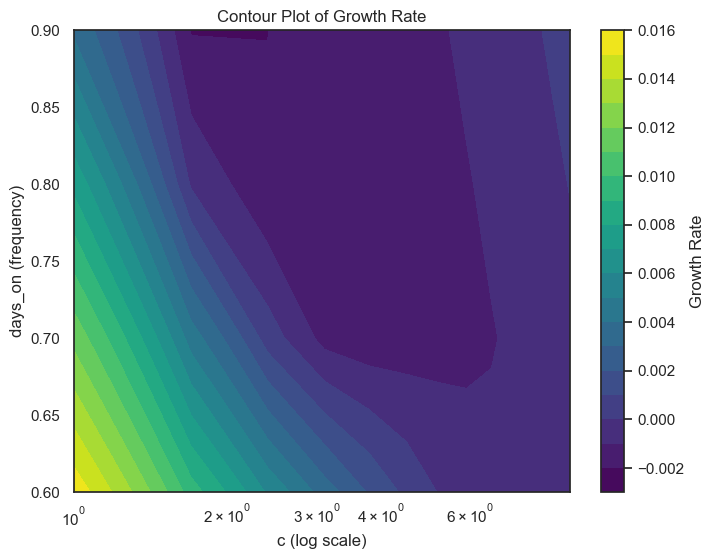

In [7]:
X = np.array([r[1] for r in RES])
Y = np.array([r[0] for r in RES])/7
Z = np.array([r[2] for r in RES])

# Reshape X, Y, Z to create grids for contour plotting
num_freq = len(np.unique(Y))
num_c = len(np.unique(X))

X_grid = Y.reshape((num_freq, num_c))
C_grid = X.reshape((num_freq, num_c))
Z_grid = Z.reshape((num_freq, num_c))

plt.figure(figsize=(8, 6))
contour = plt.contourf(C_grid, X_grid, Z_grid, levels=20, cmap='viridis')
plt.xscale('log')
plt.colorbar(contour, label='Growth Rate')
plt.xlabel('c (log scale)')
plt.ylabel('days_on (frequency)')
plt.title('Contour Plot of Growth Rate')
plt.show()

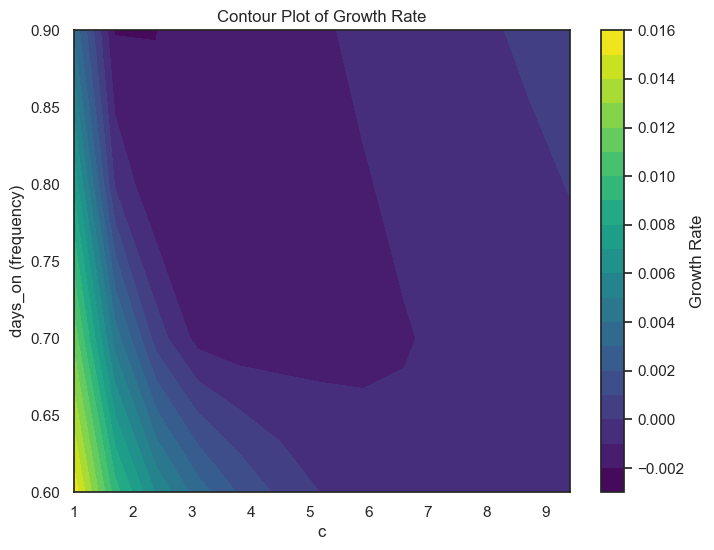

In [8]:
X = np.array([r[1] for r in RES])
Y = np.array([r[0] for r in RES])/7
Z = np.array([r[2] for r in RES])

# Reshape X, Y, Z to create grids for contour plotting
num_freq = len(np.unique(Y))
num_c = len(np.unique(X))

X_grid = Y.reshape((num_freq, num_c))
C_grid = X.reshape((num_freq, num_c))
Z_grid = Z.reshape((num_freq, num_c))

plt.figure(figsize=(8, 6))
contour = plt.contourf(C_grid, X_grid, Z_grid, levels=20, cmap='viridis')
plt.colorbar(contour, label='Growth Rate')
plt.xlabel('c')
plt.ylabel('days_on (frequency)')
plt.title('Contour Plot of Growth Rate')
plt.show()

In [ ]:
# From Simulations
RES2 = []
for frequency in np.arange(4.2, 7, 0.25):
    for c in np.arange(1, 10, 0.25):
        params = {'DMax': 100,
                'CASE': 'Chosen Above',
                'n': 1500,
                'fracRes': 0.01,
                'Cmax': 10,
                'k': 0.0004,
                'm': 0.0004,
                'u0': 0.0004,
                'v0': 0.004,
                'delta_u': 0.004,
                'delta_v': 0.003,
                'lambda0': 0.04,
                'lambda1': 0.001,
                'delta_d0': 0.08,
                'days_on': frequency,
                'c': c}
        RES2.append((frequency, c, simulate2(params)))


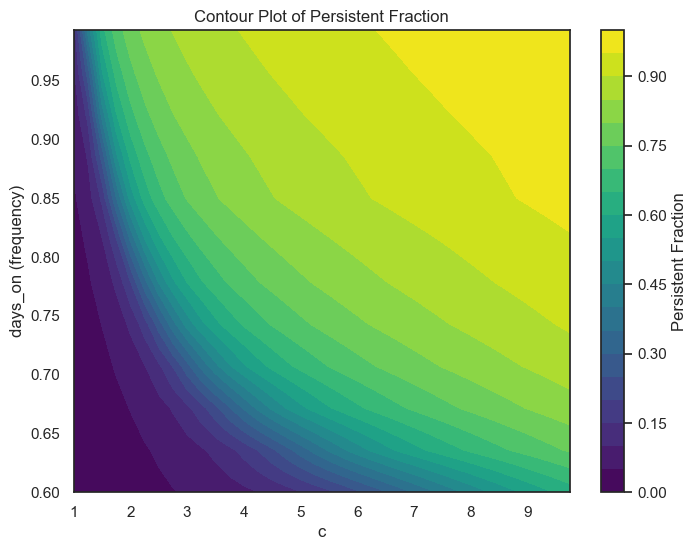

In [ ]:
x = np.array([r[1] for r in RES2])
y = np.array([r[0] for r in RES2])/7
z = np.array([r[2] for r in RES2])

# Reshape X, Y, Z to create grids for contour plotting
num_freq = len(np.unique(y))
num_c = len(np.unique(x))

X_grid = y.reshape((num_freq, num_c))
C_grid = x.reshape((num_freq, num_c))
Z_grid = z.reshape((num_freq, num_c))

plt.figure(figsize=(8, 6))
contour = plt.contourf(C_grid, X_grid, Z_grid, levels=20, cmap='viridis')
plt.colorbar(contour, label='Persistent Fraction')
plt.xlabel('c')
plt.ylabel('days_on (frequency)')
plt.title('Contour Plot of Persistent Fraction')
plt.show()